In [264]:
import math
import warnings
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

__Set Parameters for Simulated Data Generation:__

The cell immediately below will set parameters to be used when generating the stim_data and stim_responses text files to be used for downstream analysis.

In [157]:
#set parameters for stim_data
stim_interval = 100 #interstimulus interval time
dim1_min = 1 #min x value
dim1_max = 10 #max x value
dim2_min = 1 #min y value
dim2_max = 10 #max y value

#set parameters for stim_responses
num_neurons = 10 #number of simulated neurons to generate
num_frames = 4000 #number of frames/response values per neuron
max_response = 20.0 #max response that a neuron's ap can reach (set for easier visualization)
no_response_prob = 0.3 #probability of stimulus not inducing any response

__Simulated Data Generation:__

The functions in the following cells (_generate_stim_data_, _generate_ap_, and _generate_stim_responses_) will create the stim_data.txt and stim_responses.txt files that contain the simulated neural responses to stimulus occurrences. 

These two files will serve as the primary input for the rest of analysis performed in this notebook, and are saved to the directory containing this notebook.

_generate_stim_data_ will create the stim_data.txt file, containing three columns of values; the first representing the frame number where a theoretical visual stimulation would occur, inducing an action potential in the neuron(s) we are measuring. The second and third columns contain values that would represent specific characteristics of the visual stimulus being shown. For example, in an experimental context, this could represent a different stimulus shape, size, color, etc.

_generate_ap_ will produce a gaussian-like spike representing a simulated action potential after the visual stimulus is "shown", and _generate_stim_responses_ will append these respective spikes for each neuron and output the stim_responses.txt file containing these values.

In [181]:
def generate_stim_data():
    
    #make values for stim onset
    col1 = np.arange(stim_interval, num_frames, stim_interval)

    num_stimuli = len(col1)

    #create random values for dim1 and dim2
    col2 = np.random.randint(dim1_min, dim1_max+1, size=num_stimuli)
    col3 = np.random.randint(dim2_min, dim2_max+1, size=num_stimuli)  
    
    #combine
    data = np.column_stack((col1, col2, col3))

    #save
    file_name = "stim_data.txt"
    np.savetxt(file_name, data, delimiter=' ', fmt='%d')
    num_stimuli = (num_frames // stim_interval)

    print(f"File {file_name} has been created with {num_stimuli-1} stimuli")
    
    return num_stimuli

num_stimuli = generate_stim_data()  

File stim_data.txt has been created with 39 stimuli


In [183]:
def generate_ap(width, amplitude):
    
    ap = np.zeros(width) #np.random.randint(0, 1, width)
    midpoint = width // 2
    
    #make Gaussian-like spike
    for i in range(width):
        ap[i] = amplitude * np.exp(-((i - midpoint) ** 2) / (2 * (width / 6) ** 2))
        
    return ap

def generate_stim_responses():
    
    #initialize matrix with zeros
    matrix = np.zeros((num_neurons, num_frames))

    #make aps and insert into matrix
    for i in range(1, num_stimuli):
        stimulus_start = i * stim_interval
        stimulus_end = stimulus_start + stim_interval

        for neuron in range(num_neurons):

            if np.random.rand() < no_response_prob:
                # No response for this stimulus
                continue

            #create random amplitude and width for each neuron
            amplitude = np.random.uniform(1, max_response) 
            width = np.random.randint(5, 50)
            ap = generate_ap(width, amplitude)

            #place ap into matrix
            ap_start = stimulus_start + np.random.randint(0, stim_interval - width)
            ap_end = ap_start + width
            matrix[neuron, ap_start:ap_end] += ap

    file_name = "stim_responses.txt"
    np.savetxt(file_name, matrix, fmt='%.2f')

    print(f"File {file_name} has been created for {num_neurons} neurons with {num_frames} responses")
    
generate_stim_responses()

File stim_responses.txt has been created for 10 neurons with 4000 responses


__Set File Locations of Simulated Data:__

After generating the simulated data above, we set the locations of the files to their respective response_data and stim_data variables to be reference throughout the rest of the analysis.

In [142]:
response_data = "./stim_responses.txt"
stim_data = "./stim_data.txt"

__Retrieve Neural Responses:__

The function below creates a dictionary (_neurons_responses_dict_) where each key is a different neuron and the values for each neuron represent the strength of response at each frame.

If this was experimental data, these values would represent the respective neuron's response over time while it is being recorded after multiple stimulus appearances. Based on the imaging/recording method, it is likely that artifacts or very low-quality neurons would be recorded during the experiment as well. This would require an additional filtering or QC step to ensure that only high-quality neurons are being taken into analysis.

Since the goal of this project is to attempt to perform an analysis that closely mimics the steps required of experimental data, we also correct for "background noise", or in the simulated case, randomness. We apply a Savitzky-Golay filter to our population average to create a smoothed, fitted line to our data that represents a "baseline". This baseline is used to normalize each individual neuron's signal to help reduce simulated background noise and bring out real peaks. 

In [185]:
def get_responses(response_data):
    
    with open(response_data, 'r') as file:
        neurons_responses = file.readlines()
        
    neurons_responses_dict = {key:[] for key in range(1, (len(neurons_responses)+1))}

    #append response at each frame for each neuron
    for neuron in range(len(neurons_responses)):
        neurons_responses_dict[neuron+1] = neurons_responses[neuron].strip("\n").split(" ")
        
    for neuron, responses in neurons_responses_dict.items():
        neurons_responses_dict[neuron] = [float(response) for response in responses if response != 'nan']
    
    responses_list = list(iter(neurons_responses_dict.values()))
    
    avg_responses_dict={'N_avg':[] for value in range(num_frames)}

    #get frame averages column-wise
    for response in range(len(responses_list[0])):
        frame_list = [frame[response] for frame in responses_list] 
        avg_responses_dict['N_avg'].append(sum(frame_list)/len(frame_list)) 
        
    #calculate average and correct by savitzky golay filter application

    return neurons_responses_dict, avg_responses_dict
        
neurons_responses_dict, avg_responses_dict = get_responses(response_data)

__Plot Neural Traces:__

We can visualize the traces of each neuron below, where the blue line indcates the neuron's response over the course of the "experiment". Additionally, stimuli appearances are indicated by either orange or green vertical bars in the background, depending on whether dim1 or dim2 is chosen to be displayed.

In [187]:
def neural_traces(response_data, stim_data, parameter, neuron):
    
    with open(stim_data) as file:
        stimuli = file.readlines()

    stimuli_list = []
    frames_list = []

    #append list of frames where stimulus occurrence appears
    for i in zip(stimuli):
        stimuli_list.append(i[0].split(" ", 1)[0])
        frames_list.append(i[0].strip("\n").split(" "))

    stimuli_list = [eval(y) for y in stimuli_list] #convert scientific notation to decimals
    stimuli_list.sort()

    param_list = []

    #append values of parameter corresponding to stimulus shown at respective frame
    for i in frames_list:
        if parameter == 'dim1':
            param_list.append(float(i[2]))
        elif parameter == 'dim2':
            param_list.append(float(i[1]))

    if parameter == 'dim1':
        original_cmap = cm.colormaps["Oranges"]
        dim_min = dim1_min
        dim_max = dim2_max
    elif parameter == 'dim2':
        original_cmap = cm.colormaps["Greens"]
        dim_min = dim2_min
        dim_max = dim2_max

    #truncate colorbar
    new_colors = original_cmap(np.linspace(0.2, 1))
    truncated_cmap = LinearSegmentedColormap.from_list('truncated_cmap', new_colors)

    param_list = np.array(param_list) 
    norm = Normalize(dim_min, vmax=dim_max) 

    fig, ax = plt.subplots(figsize=(12, 6))
    
    if neuron == 'all':
        ax.plot(range(num_frames), avg_responses_dict.get("N_avg"), label = "Avg Neural Response")
        plt.title(f"Avg Neural Response")
    else:
        if neuron in neurons_responses_dict.keys():
            ax.plot(range(num_frames), neurons_responses_dict.get(neuron))
            plt.title(f"Neuron {neuron} Neural Response")
        else:
            print("Neuron not in dictionary. Please choose different neuron")

    for stimulus, param_val in zip(stimuli_list, param_list):
        ax.axvline(x=stimulus, color = truncated_cmap(norm(param_val)), linewidth = "0.5")

    sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
    sm.set_array(param_list)
    cbar = plt.colorbar(sm, ax=ax, label = f'{parameter}')
    plt.xlim(0, num_frames)
    plt.ylim(0, max_response)
    plt.xlabel("Frames")
    plt.ylabel("Response Strength")
    plt.tight_layout()
    
    plt.show()

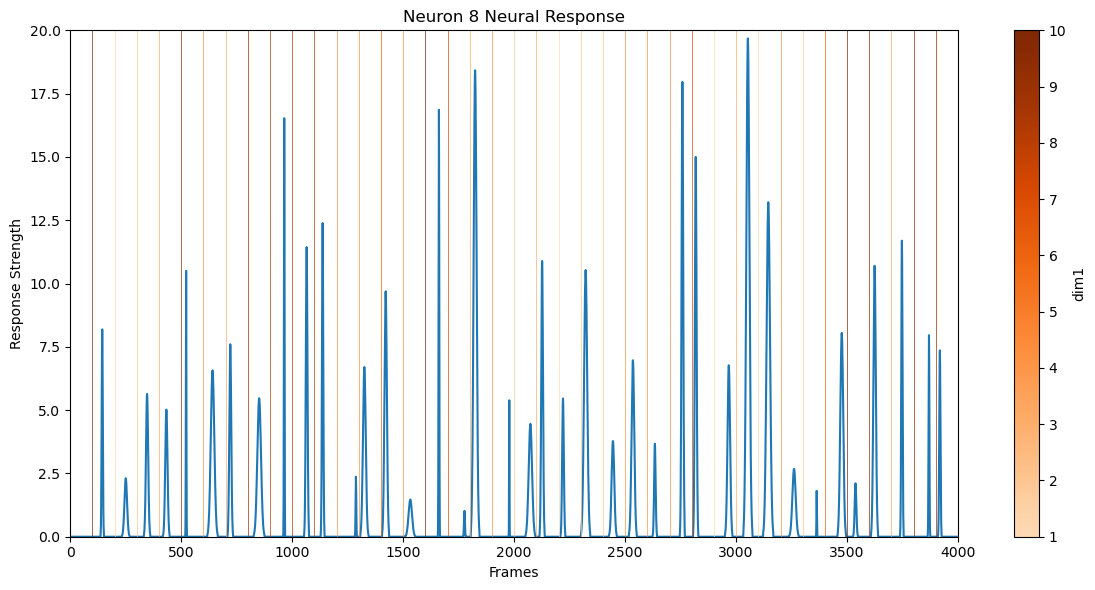

In [196]:
neural_traces(response_data, stim_data, "dim1", 8)

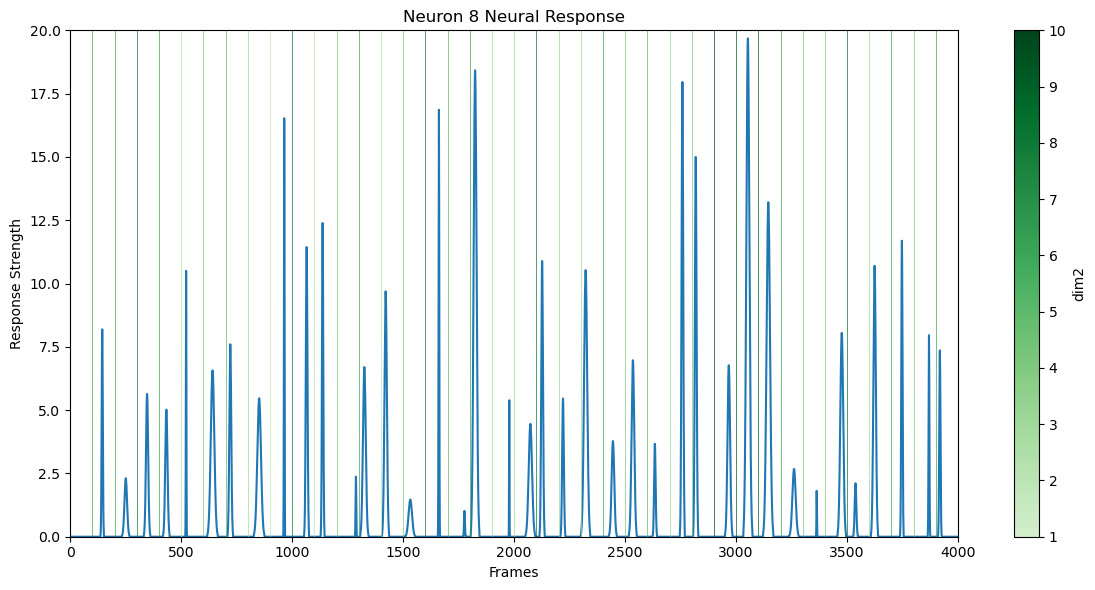

In [194]:
neural_traces(response_data, stim_data, "dim2", 8)

In an experimental context, we could plot the neural responses at each frame for all neurons in our dataset to visualize patterns or distributions in our neural population. These patterns could inform us of specific combinations of parameters, such as values of dim1 and dim2 which represent different characteristics of a visual stimuli, that are responsible for eliciting the greatest neural responses within a subpopulation.

However, since this is randomly generated data based off of a normal distribution, the average neural response below is not as informative. Additionally, the simulated data generated above does not have any real noise associated with it, which is obviously unlike experimental neural signals. Regardless, we can interpet randomness from our small sample size as variance in signal caused by our stimulus occurrences, even though this is clearly not the case.

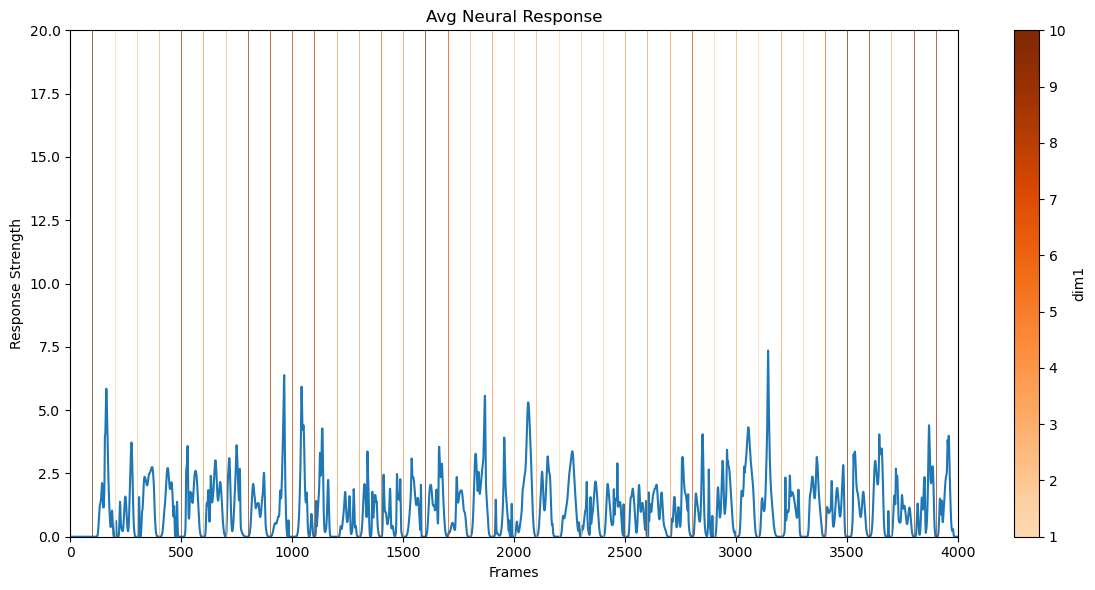

In [198]:
neural_traces(response_data, stim_data, "dim1", 'all')

__Parameter-Specific Peak Structure:__

The section below aims to extract information regarding how specific values of dim1 and dim2 (our theoretical visual stimulus) elicits changes in neural response amplitude, shape, and location across the population of cells.

Subplots that are left blank are a result of a lack of sampling during the simulated data generation.

interstimulus interval: 100


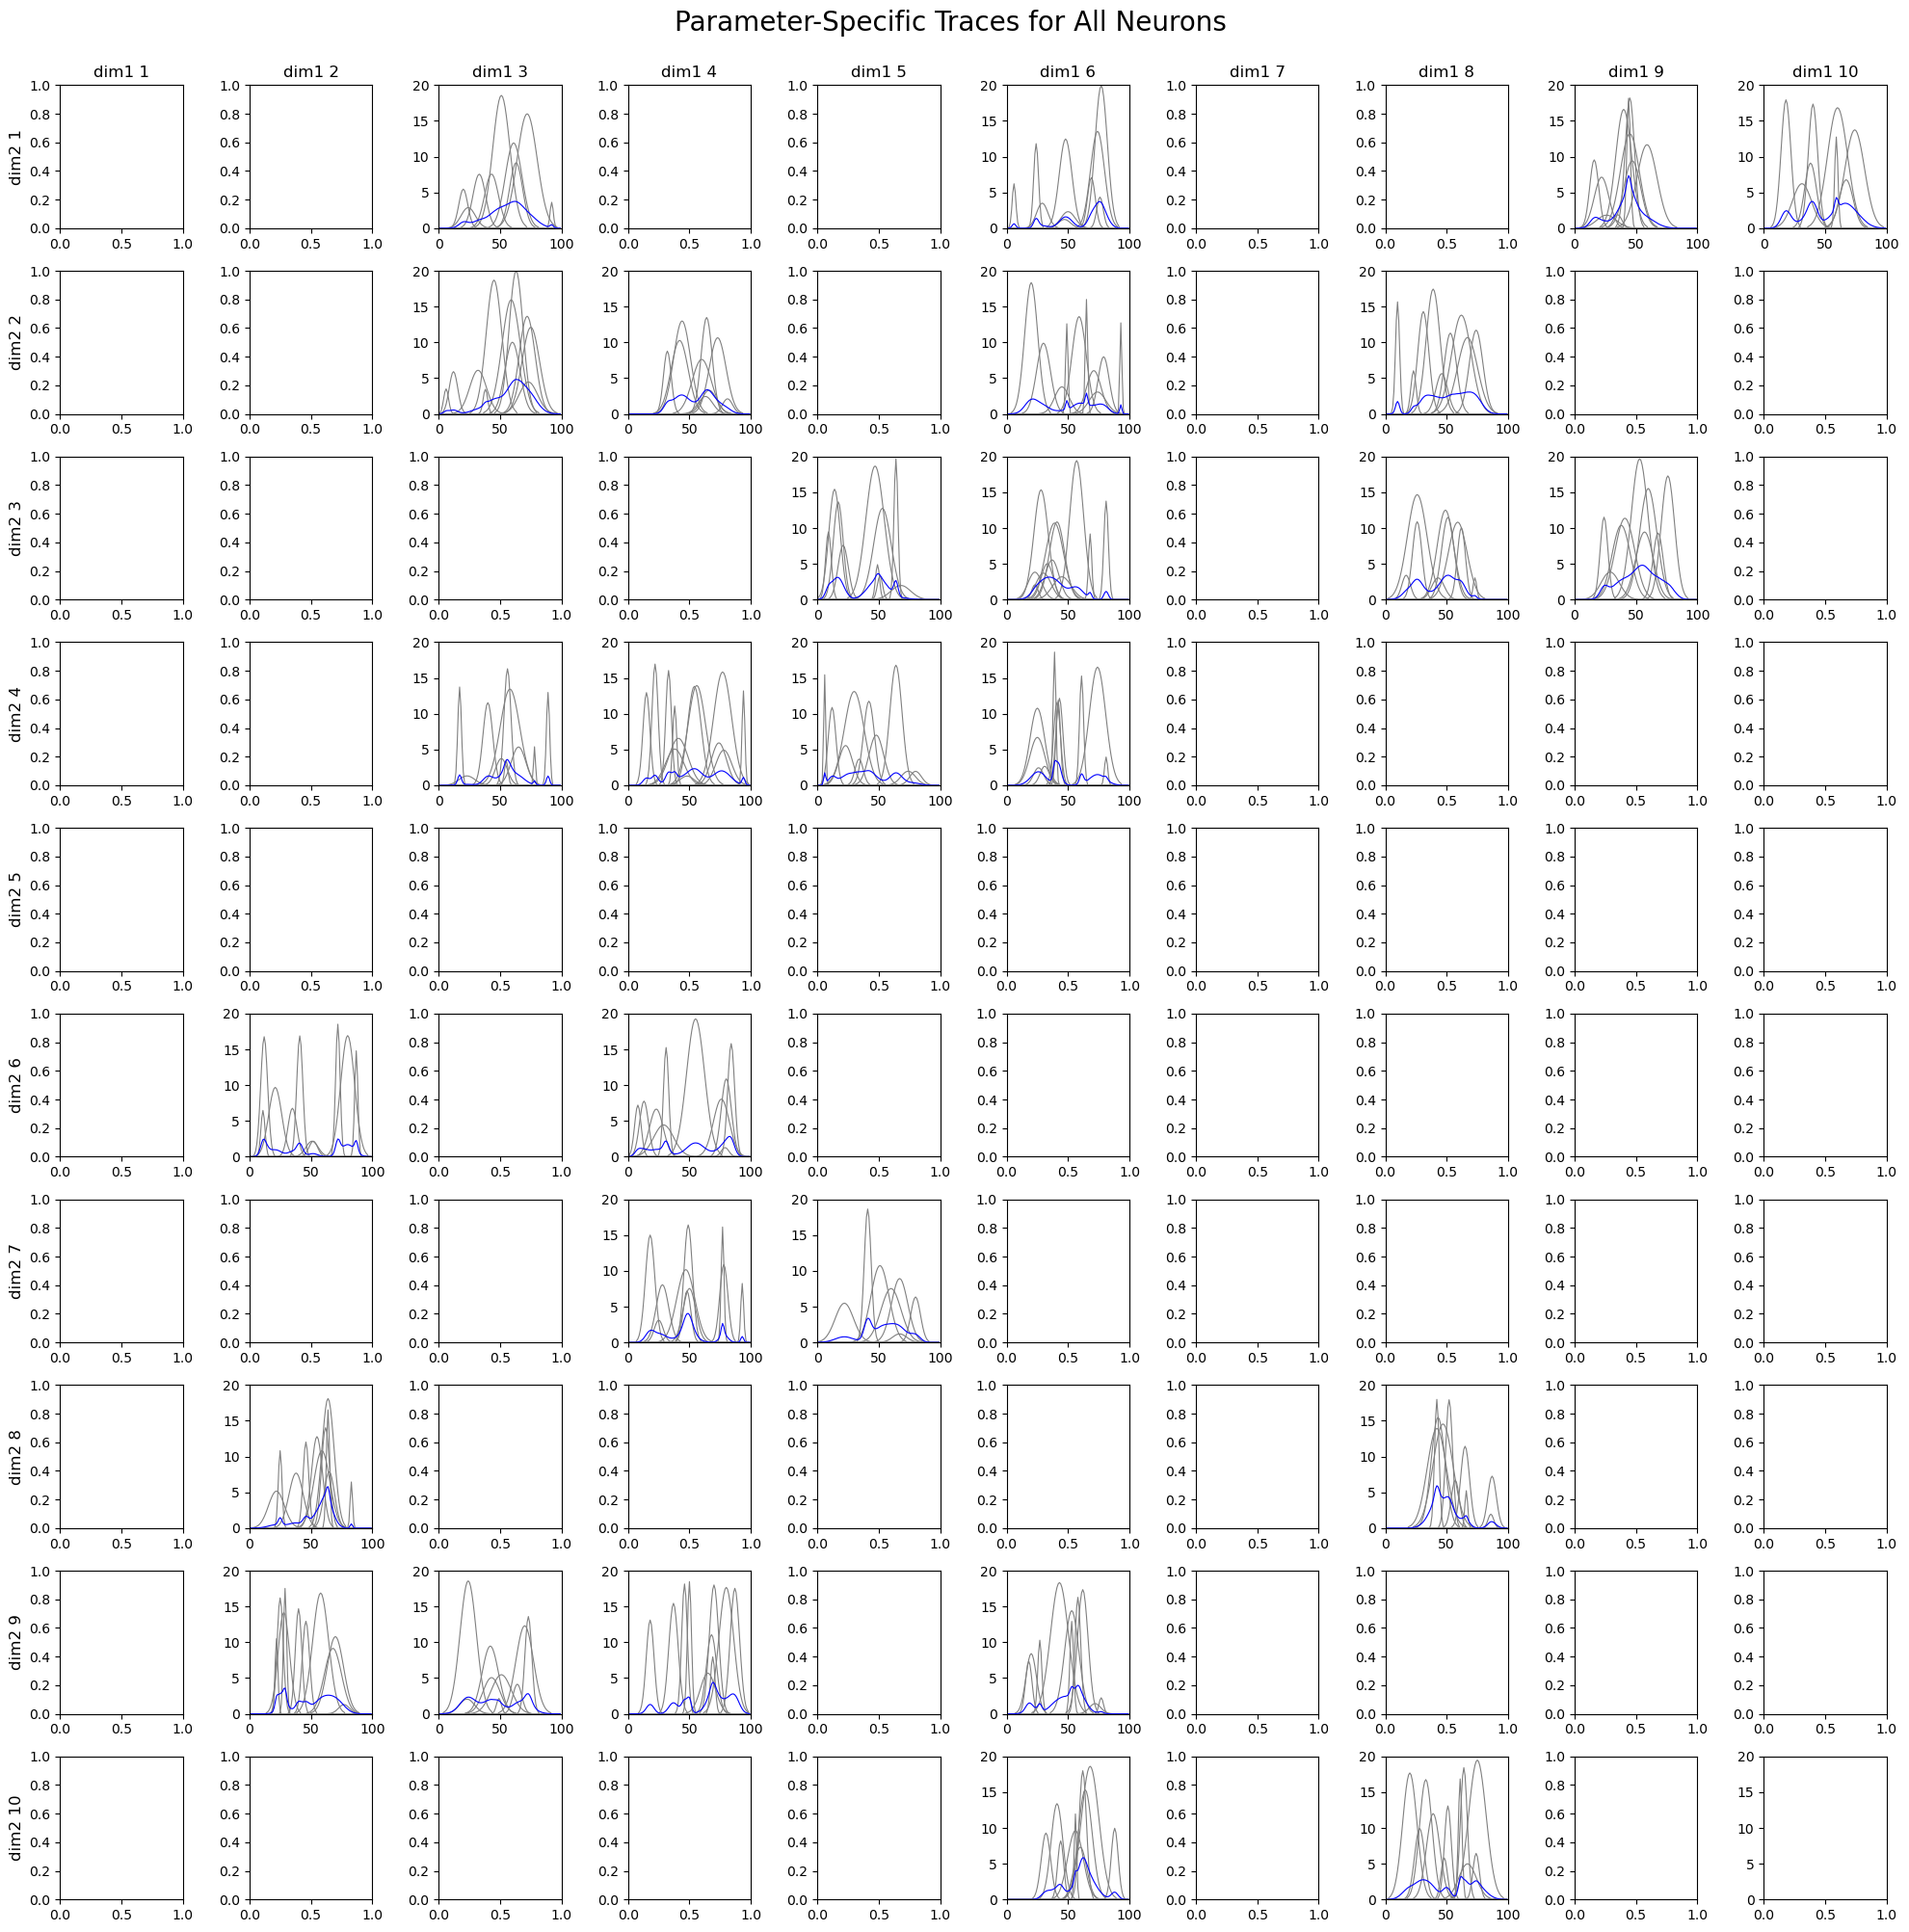

In [200]:
def stim_combo_analysis(stim_data):
    
    with open(stim_data) as file:
        stimuli = file.readlines()
        
    all_stim_info = []
    for i in zip(stimuli):
        all_stim_info.append(i[0].strip("\n").split(" "))
    
    #convert stim to floats and append to list
    for idx, stim in enumerate(all_stim_info):
        stim = [eval(param) for param in stim]
        all_stim_info[idx] = stim
    
    return all_stim_info

def stim_combo_plot_indiv(ax, all_stim_info, neuron, val1, val2):
    
    stim_combo_start = []
    
    #find frame where param combo occurs
    for stim in all_stim_info:
        if val1 == stim[1] and val2 == stim[2]:
            stim_combo_start.append(int(stim[0]))

    if len(stim_combo_start) > 0:
        
        #find window length corresponding to stimulus onset
        traces_avg = {}
        for stim in stim_combo_start:
            traces_avg[stim] = [[] for i in range(stim_interval)]

            #iterate through each neuron and append response at respective frame to corresponding position in dictionary
            if neuron == 'all':
                for neuron in neurons_responses_dict:
                    if sum(neurons_responses_dict[neuron][stim:stim+stim_interval]) >= 10: 
                        ax.plot(range(0, stim_interval), neurons_responses_dict[neuron][stim:stim+stim_interval], color = "grey", lw = '0.8')

                        for val_idx, val in enumerate(neurons_responses_dict[neuron][stim:stim+stim_interval]):
                            traces_avg[stim][val_idx].append(val)
                      
            else:
                if sum(neurons_responses_dict[neuron][stim:stim+stim_interval]) >= 10: 
                    ax.plot(range(0, stim_interval), neurons_responses_dict[neuron][stim:stim+stim_interval], color = "grey", lw = '0.8')

                    for val_idx, val in enumerate(neurons_responses_dict[neuron][stim:stim+stim_interval]):
                        traces_avg[stim][val_idx].append(val)
                else:
                    traces_avg.pop(stim)
                        
        if len(traces_avg) == 0:
            traces_avg = None
                                  
    else:
        traces_avg = None
     
    plt.ylim(0,max_response)
    
    return traces_avg
                                                        
def stim_combo_plot_avg(ax, traces_avg):
    
    #truncate or extend dict to be same length (max_window)
    for frame, response in traces_avg.items():
        if len(response) > stim_interval:
            traces_avg[frame] = traces_avg[frame][:stim_interval]
        elif len(response) < stim_interval:
            traces_avg[frame].append([0] * (stim_interval - len(response)))
                       
    values = [[] for i in range(stim_interval)]
    for i in range(stim_interval):
        for key, responses in traces_avg.items():
            for response in responses[i]:
                if response != None:
                    values[i].append(response)

    #calculate average at each frame for all responses in stim window
    avg_list = []
    for i in values:
        if len(i) > 0:
            average = sum(i)/len(i)
            avg_list.append(average)
            
    if len(avg_list) > 0:
        ax.plot(range(0,len(avg_list)), avg_list, color = "blue", lw = "0.8")
        ax.set(xlim=(0,len(avg_list)), ylim = (0,max_response))
        
    plt.ylim(0,max_response)

all_stim_info = stim_combo_analysis(stim_data)

param1 = list(range(dim1_min, dim1_max+1))
param2 = list(range(dim2_min, dim2_max+1))

rows = ['dim1 {}'.format(row) for row in param1]
cols = ['dim2 {}'.format(col) for col in param2]

fig, axs = plt.subplots(len(param1), len(param2), figsize = (20,20))
fig.suptitle('Parameter-Specific Traces for All Neurons', fontsize = 20, x=0.5, y=1)
for ax, row in zip(axs[0], rows):
    ax.set_title(row)

for ax, col in zip(axs[:,0], cols):
    ax.set_ylabel(col, rotation=90, size='large')
axs = axs.flatten()

param_idx = 0

#iterate through each combo of size-speed and analyze corresponding stimON window
for val2 in param2:
    for val1 in param1:
        traces_avg = stim_combo_plot_indiv(axs[param_idx], all_stim_info, 'all', val1, val2)
        if traces_avg != None:
            stim_combo_plot_avg(axs[param_idx], traces_avg)
        param_idx += 1

plt.tight_layout()
plt.show()

__Non-interpolated Tuning Curves:__

Having identified potential patterns in peak location, amplitude, and structure across our neural population in response to visual stimuli with varying characteristics, our next step is to identify which parameter combinations most consistently induce the greatest neural responses. 

This can be accomplished by plotting non-interpolated neural tuning curves, which highlight the amplitude of response across all neurons in our population and map them to their specific stimulus that induced the response.

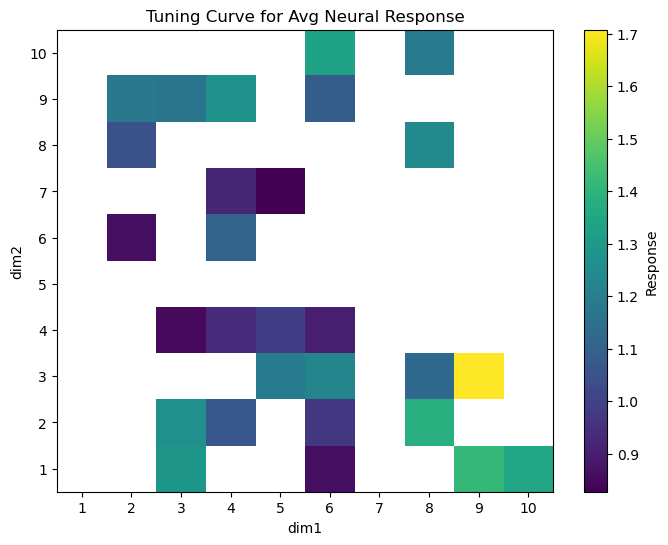

In [225]:
def tuning_curves_analysis(stim_data, neuron):
    
    all_stim_info = stim_combo_analysis(stim_data)
    
    all_combos = np.array([(x, y) for x in param1 for y in param2])
    
    param1_frames = {key:[] for key in param1}
    param2_frames = {key:[] for key in param2}
        
    #appending frame of matching unqiue param tested as value
    for stim in all_stim_info:
        stim_param1 = stim[1]
        stim_param2 = stim[2]
        
        for param in param1:
            if param == stim_param1:
                param1_frames[param].append(stim[0])
                
        for param in param2:
            if param == stim_param2:
                param2_frames[param].append(stim[0])
               
    #dict that will contain stimulus onset frame and the neural responses within the stimulus window
    stim_responses = {}

    #assign the values (stimulus onset frames) from parameter_uniqvals_frames_dict their own dict as a key
    for param, frames in param1_frames.items():
        for frame in frames:
            stim_responses[frame] = []
            
    for frame, response in stim_responses.items():
        frame_idx = 0
        for stim in all_stim_info:
            frame_idx += 1

            #finding range/window of frames that correspond to stimulus onset
            if frame == stim[0] and frame_idx < len(all_stim_info):
                frame_start = int(frame)
                frame_end = int(all_stim_info[frame_idx][0])

                #adding neural response frames that correspond to selected stimulus window
                if neuron == 'all':
                    for avg_frame in avg_responses_dict['N_avg'][frame_start:frame_end]:
                        stim_responses[frame].append(avg_frame)
                        
                else:
                    for neuron_frame in neurons_responses_dict[neuron][frame_start:frame_end]:
                        stim_responses[frame].append(neuron_frame)

            #identifying frame window when analyzing last stimulus onset
            elif frame == stim[0] and frame_idx == len(all_stim_info):
                frame_start = int(frame)
                frame_end = int(len(avg_responses_dict['N_avg']))

                #adding neural response frames that correspond to selected stimulus window
                if neuron == 'all':
                    for avg_frame in avg_responses_dict['N_avg'][frame_start:frame_end]:
                        stim_responses[frame].append(avg_frame)
                        
                else:
                    for neuron_frame in neurons_responses_dict[neuron][frame_start:frame_end]:
                        stim_responses[frame].append(neuron_frame)
    
    #calculating average of all responses within selected window for each different stimulus onset
    for stim, responses in stim_responses.items():
        if len(responses) == 0:
            stim_responses[stim] = np.nan
        else:
            stim_responses[stim] = (sum(responses)/len(responses))
                
    stim_responses = sorted(stim_responses.items())
            
    for idx, i in enumerate(stim_responses):
        all_stim_info[idx].append(i[1])
        
    responses_map = {}
    avg_map = {}
    for row in all_combos:
        responses_map[tuple(row)] = []
        avg_map[tuple(row)] = []
    
    #appending average values associated with unique combo of parameters
    for combo in avg_map:
        for stim in all_stim_info:
            if combo[0] == stim[1] and combo[1] == stim[2]:
                responses_map[combo].append(stim[3])
                avg_map[combo].append(stim[3])
    
    #calculating average and replacing non-sampled spaces with nan
    for combo, response in avg_map.items():
        if len(response) > 0:
            avg_map[combo] = sum(response)/len(response)
            if avg_map[combo] == 0:
                avg_map[combo] = np.nan
        else:
            avg_map[combo] = np.nan
                        
    return all_combos, responses_map, avg_map, stim_responses, param1_frames, param2_frames

def tuning_curves_plot(stim_data, neuron):
    
    all_combos, responses_map, avg_map, stim_responses, param1_frames, param2_frames = tuning_curves_analysis(stim_data, neuron)
    
    fig, ax = plt.subplots(figsize=(8, 6))

    known_values = np.array([response for response in avg_map.values() if response])
    interped_data = known_values.reshape(len(param1), len(param2))
    
    plt.imshow(interped_data.T, origin = 'lower', aspect = 'auto')
    plt.colorbar(label='Response')
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.xticks(np.arange(len(param2)), param2)
    plt.yticks(np.arange(len(param1)), param1)
    plt.title(f'Tuning Curve for Avg Neural Response')
     
    plt.show()
    
tuning_curves_plot(stim_data, 'all')

From the above tuning curve we can identify a clear peak at dim1 = 9 and dim2 = 3, indicating a neural preference for a theoretical visual stimulus that contains these characteristics. 

Continuing the analysis, we can further extract information regarding the neural population's preferences. More specifically, whether this peak we have identified is statistically significant, and if it is more likely to be a result of the change in value of dimension 1 or dimension 2.

First, however, it is beneficial to produce subplots of tuning curves for each of the neurons in our simulated dataset. This way, we can identify whether this peak identified above is a result of a single, outlying response or a uniform response across many neurons.

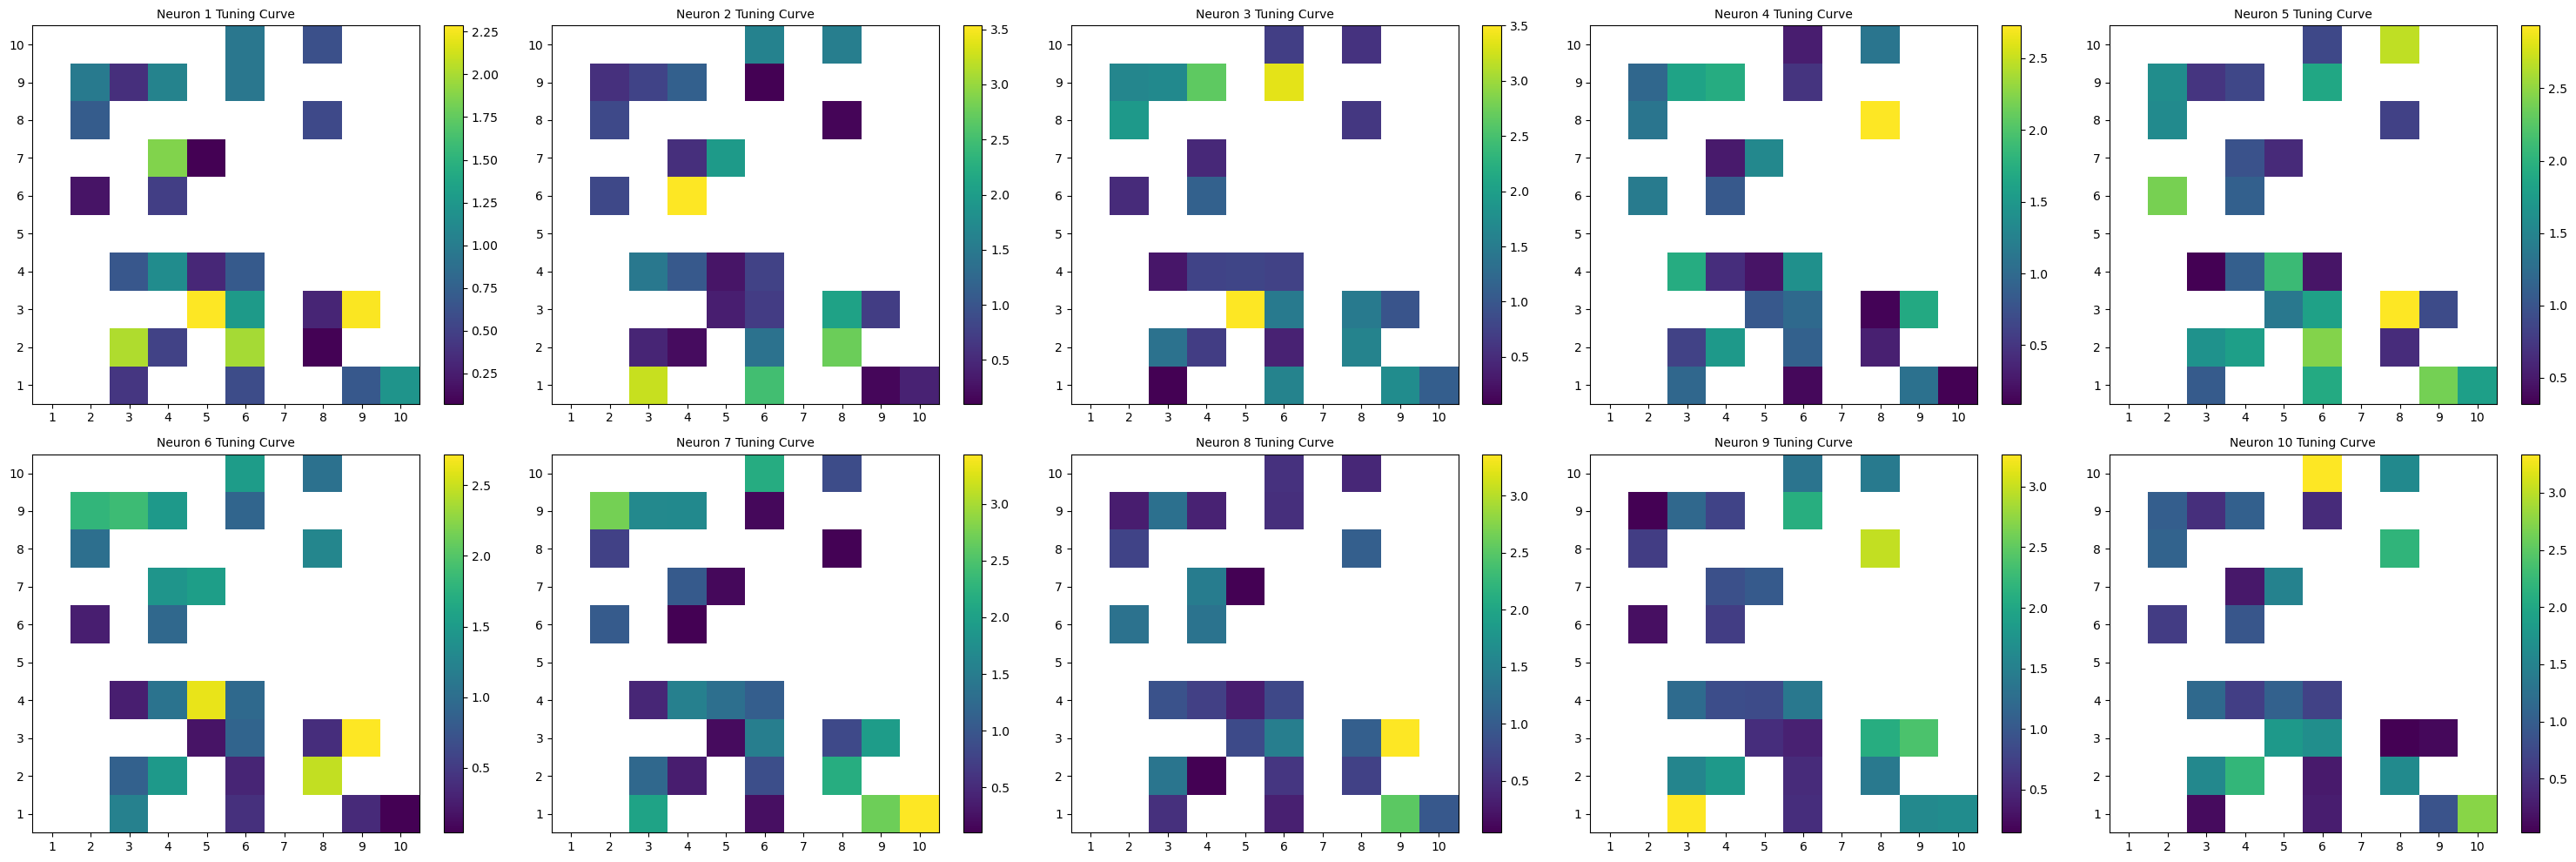

In [247]:
def tuning_curve_subplots_analysis(stim_data, neuron):
    
    all_combos, responses_map, avg_map, stim_responses, param1_frames, param2_frames = tuning_curves_analysis(stim_data, neuron)
    
    known_values = np.array([response for response in avg_map.values() if response])
    
    interped_data = known_values.reshape(len(param1), len(param2))
    
    return interped_data

def tuning_curves_subplots_plot(interped_data, neuron, ax):
    
    #plot data
    cax = ax.imshow(interped_data.T, origin = 'lower', aspect = 'auto')
    ax.set_title(f'Neuron {neuron} Tuning Curve', fontsize = 10)
    param1_label = [str(val) for val in param1]
    param2_label = [str(val) for val in param2]
    ax.set(xticks=range(0, len(param2), 1), xticklabels=param2_label, yticks=range(0, len(param1), 1), yticklabels=param1_label)
    fig.colorbar(cax, ax=ax)
    
#define subplots
fig, axs = plt.subplots(math.ceil(len(neurons_responses_dict.keys())/5), 5, figsize = (30,10))
axs = axs.flatten()

#obtain data
neuron_idx = 0
for neuron in neurons_responses_dict:
    interped_data = tuning_curve_subplots_analysis(stim_data, neuron)
    tuning_curves_subplots_plot(interped_data, neuron, axs[neuron_idx])
    neuron_idx += 1
    
plt.tight_layout()
plt.show()

Displaying individual neurons above highlights underlying patterns within our population. The previously identified peak across all neurons at dimension 1 = 9 and dimension 2 = 3 appears to be a local peak for 4/10 neurons and highly responsive for a separate 3 or 4/10 neurons, supporting the likelihood that this is a true peak rather than an outlier.

These results hold more power in an experimental context. If we were equipped with the information above, and each dimension represented a specific characteristic of a visual stimuli (say dimension 1 = speed and dimension 2 = size), we could state that our model organism has a higher preference and reaction to visual stimuli that move fast and are also small in size. Depending on the motor movement or behavior being studied, this would also provide some insight on which visual stimuli characteristics are most likely to be connected to dynamic movements during visual processing.

__Parameter-Specific Responses:__

While we can visually identify patterns using the tuning curves and other plots above, we need to identify whether these peaks are statistically significant. Furthermore, do to the nature of how the data was generated using random sampling, it is also important to take into consideration response intensity variation that is due simply to sampling differences. The plots below aim to address these aspects and inform us of potentially significant findings.

In [272]:
def parameter_responses_analysis(stim_data, parameter, neuron):
    
    all_combos, responses_map, avg_map, stim_responses, param1_frames, param2_frames = tuning_curves_analysis(stim_data, neuron)
    
    if parameter == "dim1":
        param = param1
        param_frames = param1_frames
    elif parameter == 'dim2':
        param = param2
        param_frames = param2_frames

    param_mean = {param:[] for param in param}
    param_stdev = {param:[] for param in param}
    
    for frameON, val in stim_responses:
        for stim in all_stim_info:
            if frameON == stim[0]:
                if parameter == 'dim1':
                    param_mean[stim[1]].append(val)
                elif parameter == 'dim2':
                    param_mean[stim[2]].append(val)
                    
    warnings.filterwarnings("ignore", category=RuntimeWarning)
            
    for param, vals in param_mean.items():
        stdev = np.array([vals])
        mean = np.array([vals])
        param_mean[param] = np.nanmean(mean[0], axis = 0, )
        param_stdev[param] = np.nanstd(stdev[0], axis = 0)
        
    return param_mean, param_stdev
        
def parameter_responses_plot(stim_data, parameter, neuron):
    
    param_mean, param_stdev = parameter_responses_analysis(stim_data, parameter, neuron)
        
    x = []
    y = []
    yerr = []

    #add frame of stimulus onset to x-axis and average response to stimulus as y-axis
    for param, mean in param_mean.items():
        x.append(param)
        y.append(mean)

    #add std dev as error bars
    for param, stdev in param_stdev.items():
        yerr.append(stdev)

    fig, ax = plt.subplots()
    ax.errorbar(x, y, yerr, fmt='o', linewidth=2, capsize=6)

    if parameter == "dim1":
        ax.set_ylim(bottom=0)
        ax.set_xlim(0,max(param1)+1)
    if parameter == "dim2":
        ax.set_ylim(bottom=0)
        ax.set_xlim(0,max(param2)+1)

    if neuron == "all":
        plt.title(f'Avg Neural Response Given {parameter}')
    else:
        plt.title(f'Neuron {neuron} Avg Response Given {parameter}')

    plt.xlabel(f'{parameter}')
    plt.ylabel("Avg Response")

    plt.show()

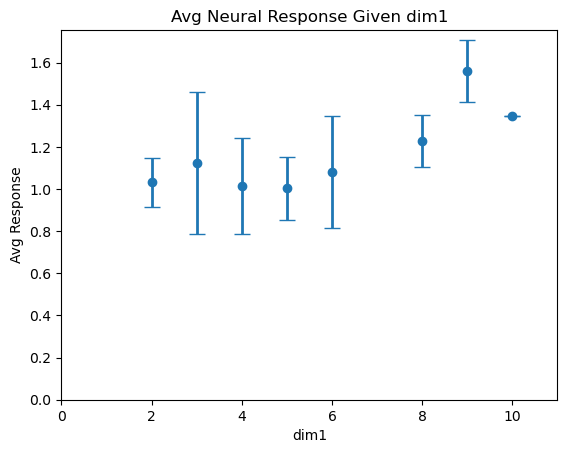

In [268]:
parameter_responses_plot(stim_data, 'dim1', 'all')

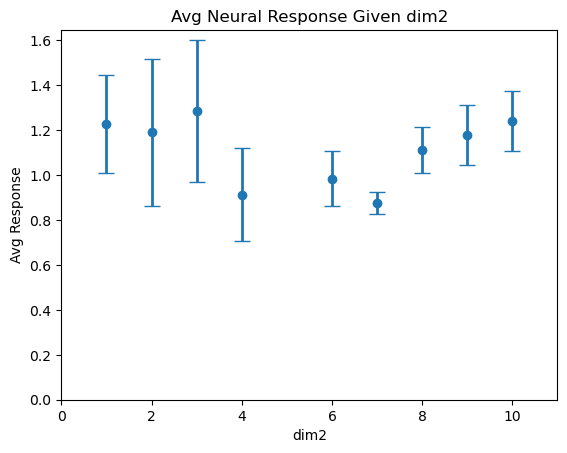

In [274]:
parameter_responses_plot(stim_data, 'dim2', 'all')

Disparities in dimension 1 sampling is evident in the first plot above, as there are no responses for both values of 1 or 7, and only a single instance of sampling value 10. Similarly, for dimension 2, there is no sampling for a value of 5.

Regardless, we can also identify a value of 9 for dimension 1 being statistically significant with a higher average response than the other values within dimension 1, and no values of dimension 2 appearing to be statistically significant. This aligns with the results shown visually from the non-interpolated tuning curves, and provides further confidence that dimension 1 plays a larger role on impacting neural response intensity than dimension 2. 

With an increased sample size in both neurons and sampling size however, these results would become less significant due to the normal distribution the data generation is based off. Keeping the sample size low in this case, however, aims to replicate skewed or significant findings that are more likely in an experimental context.